# Задача 5. Паром.

Получите accuracy > 0.89 на тестовом датасете. Можно пользоваться любым классификатором **из sklearn**. Ансамблями пользоваться можно.

### XtreemeGradientBoosting и нейронные сети запрещены. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
df = pd.read_csv('/kaggle/input/passenger-list-for-the-estonia-ferry-disaster/estonia-passenger-list.csv')


def display_data_info(df):
    print(df.head(25))
    print(df.describe(include="all"))


display_data_info(df)

    PassengerId  Country            Firstname    Lastname Sex  Age Category  \
0             1   Sweden          ARVID KALLE       AADLI   M   62        P   
1             2  Estonia                  LEA     AALISTE   F   22        C   
2             3  Estonia                 AIRI     AAVASTE   F   21        C   
3             4   Sweden                 JURI       AAVIK   M   53        C   
4             5   Sweden      BRITTA ELISABET    AHLSTROM   F   55        P   
5             6   Sweden   GERD INGA MAGNHILD    AHLSTROM   F   71        P   
6             7   Sweden              HJALMAR    AHLSTROM   M   60        P   
7             8  Estonia                PILLE       AHMAN   F   18        P   
8             9  Estonia                TORMI     AINSALU   M   30        C   
9            10   Sweden           ANNA MARIA      ALDRIN   F   63        P   
10           11   Sweden          LARS BERTIL      ALDRIN   M   67        P   
11           12  Estonia                NELLI   ALEK

In [3]:
# Создание новой категории
df["CountryType"] = df.Country.apply(
    lambda x: "Estonia" if x == "Estonia" else ("Sweden" if x == "Sweden" else "Others")
)

# Удаление ненужных колонок
df.drop(columns=["Country", "Firstname", "Lastname", "PassengerId"], inplace=True)

# Дискретизация возраста
age_discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform")
df["AgeGroup"] = age_discretizer.fit_transform(df[["Age"]])
df["AgeGroup"] = df["AgeGroup"].astype("object")

# Кодирование категориальных признаков
dummies = pd.get_dummies(
    df[["CountryType", "Sex", "Category", "AgeGroup"]], drop_first=True
)
df = pd.concat([df[["Survived", "Age"]], dummies], axis=1)

In [4]:
# Разделение данных на обучающую и тестовую выборки
x = df.drop(columns=["Survived"])
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=1338, stratify=y
)

In [5]:
# Преобразование признаков
numeric_features = ["Age"]
transformer = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), numeric_features)],
    remainder="passthrough",
)

# Настройка модели случайного леса
rf_pipeline = Pipeline(
    [
        ("feature_processing", transformer),
        ("random_forest", RandomForestClassifier(n_estimators=735, random_state=38)),
    ]
)

# Параметры для поиска
param_grid = {
    "random_forest__class_weight": [
        {0: 0.2, 1: 0.8},
        {0: 0.3, 1: 0.7},
        {0: 0.4, 1: 0.6},
        "balanced",
        "balanced_subsample",
    ]
}

# Поиск лучших параметров
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

# Оценка модели
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nОтчет о классификации на тестовой выборке:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Лучшие параметры: {'random_forest__class_weight': {0: 0.4, 1: 0.6}}

Отчет о классификации на тестовой выборке:
              precision    recall  f1-score   support

           0       0.89      0.95      0.91       256
           1       0.42      0.24      0.31        41

    accuracy                           0.85       297
   macro avg       0.65      0.59      0.61       297
weighted avg       0.82      0.85      0.83       297



In [6]:
# Создание и обучение моделей
logistic_pipeline = Pipeline(
    [
        ("feature_processing", transformer),
        ("logistic_reg", LogisticRegression(class_weight="balanced", random_state=38)),
    ]
)

svc_pipeline = Pipeline(
    [
        ("feature_processing", transformer),
        ("svc", SVC(probability=True, random_state=38, class_weight="balanced")),
    ]
)

# Объединение моделей в ансамбль
voting_clf = VotingClassifier(
    estimators=[
        ("random_forest", rf_pipeline),
        ("log_reg", logistic_pipeline),
        ("svc", svc_pipeline),
    ],
    voting="soft",
)

# Обучение ансамбля и предсказание
ensemble_model = voting_clf.fit(X_train, y_train)
predicted_labels = ensemble_model.predict(X_test)

# Отчет о классификации ансамбля
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       256
           1       0.58      0.27      0.37        41

    accuracy                           0.87       297
   macro avg       0.74      0.62      0.65       297
weighted avg       0.85      0.87      0.85       297



# Задача 6. Линрег

Допустим, у вас есть два множества **A** и **B** точек на плоскости. Линейная регрессия на плоскости -- это 
просто прямая, ее можно представить как функцию $ y = ax + b$.

Линейная регрессия, обученная на множестве **А**, имеет коэффициент **$a > 0$**. То же самое верно и для линейной регрессии, обученной на множестве **B**. Правда ли, что если обучить линейную регрессию на множестве $A \cup B$, то у полученной прямой коэффициент **a** будет больше 0?

Если да -  докажите, если нет - постройте контрпример.

Нет - потроим контрпример

Коэффициент линейной регрессии для кластера A: 0.556
Коэффициент линейной регрессии для кластера B: 0.483
Коэффициент линейной регрессии для AUB: -0.623


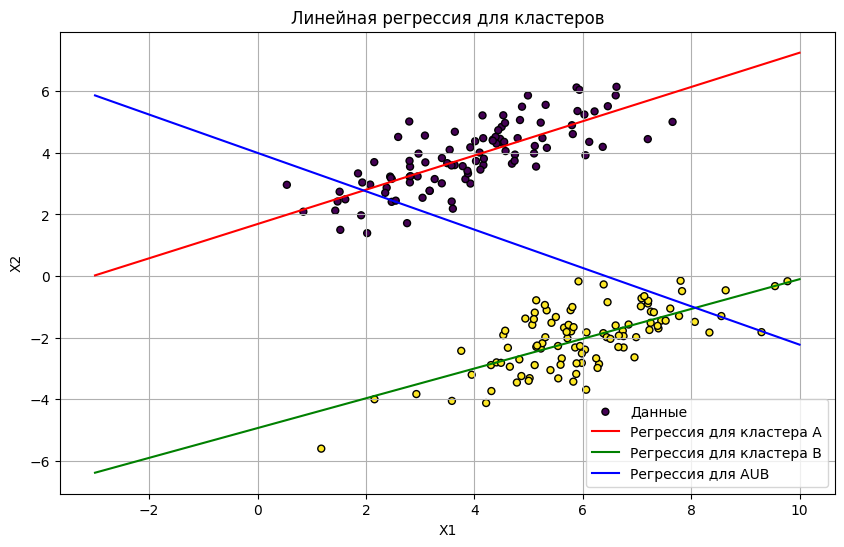

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression

X, y = make_blobs(
    n_samples=200, centers=[(0, 4), (8, -2)], cluster_std=1.0, n_features=2
)
X = np.dot(X, np.array([[1, 0], [1, 1]]))

# Разделение данных на два кластера
X_cluster_0 = X[y == 0]
X_cluster_1 = X[y == 1]

# Обучение линейной регрессии для каждого кластера
model_0 = LinearRegression().fit(X_cluster_0[:, 0].reshape(-1, 1), X_cluster_0[:, 1])
model_1 = LinearRegression().fit(X_cluster_1[:, 0].reshape(-1, 1), X_cluster_1[:, 1])
model_combined = LinearRegression().fit(X[:, 0].reshape(-1, 1), X[:, 1])

x_range = np.linspace(-3, 10, 100).reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=25, edgecolor="k", label="Данные")
plt.plot(
    x_range, model_0.predict(x_range), color="red", label="Регрессия для кластера A"
)
plt.plot(
    x_range, model_1.predict(x_range), color="green", label="Регрессия для кластера B"
)
plt.plot(
    x_range,
    model_combined.predict(x_range),
    color="blue",
    label="Регрессия для AUB",
)
plt.grid()
plt.legend()
plt.title("Линейная регрессия для кластеров")
plt.xlabel("X1")
plt.ylabel("X2")

# Вывод коэффициентов
print(f"Коэффициент линейной регрессии для кластера A: {np.round(model_0.coef_[0], 3)}")
print(f"Коэффициент линейной регрессии для кластера B: {np.round(model_1.coef_[0], 3)}")
print(
    f"Коэффициент линейной регрессии для AUB: {np.round(model_combined.coef_[0], 3)}"
)

plt.show()